<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/ResNet50_MVtec_AD_Dataset_label_88_%EB%B3%91%EC%A3%BC%EB%8B%98%EC%9E%91%EC%84%B1%EC%BD%94%EB%93%9C%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os # miscellaneous operating system interfaces
import shutil # high-level file operations
from tqdm import tqdm
from glob import glob

In [3]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

## 데이터셋 로드

In [4]:
## 저장한 x,y. 배열 가져오기
# 배열로 불러오기
base_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open'
train_base_dir = base_dir + '/train_label_88'
xy_savez_load = np.load(f"{train_base_dir}/imageset_224*224.npz")
type(xy_savez_load)
X = xy_savez_load['x']
Y = xy_savez_load['y']

# 저장한 배열로 학습 / 검증 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y) # test_size=0.25(default)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [5]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [6]:
def ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
model = ResNet50(input_shape = (224, 224, 3), classes = 88)

In [8]:
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 109, 109, 64  256         ['conv1[0][0]']                  
                                )                                                          

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=f'{train_base_dir}/reset50_with_classifiers_88_test_220422.h5', monitor='loss', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [11]:
## 원활한 비교를 위해 batch_size=64, epochs=25
hist = model.fit(X_train, y_train, batch_size=64, epochs=25, validation_data=(X_test, y_test), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/25
51/51 [==============================] - 42s 762ms/step - loss: 19.4729 - accuracy: 0.2554 - val_loss: 554.4596 - val_accuracy: 0.0607
Epoch 2/25
51/51 [==============================] - 38s 740ms/step - loss: 3.5530 - accuracy: 0.7138 - val_loss: 4.1630 - val_accuracy: 0.0598
Epoch 3/25
51/51 [==============================] - 38s 743ms/step - loss: 3.3156 - accuracy: 0.7689 - val_loss: 4.0001 - val_accuracy: 0.4178
Epoch 4/25
51/51 [==============================] - 33s 646ms/step - loss: 6.6740 - accuracy: 0.7256 - val_loss: 278211.2500 - val_accuracy: 0.0533
Epoch 5/25
51/51 [==============================] - 33s 649ms/step - loss: 3.9095 - accuracy: 0.7016 - val_loss: 6.3088 - val_accuracy: 0.1579
Epoch 6/25
51/51 [==============================] - 37s 736ms/step - loss: 3.0012 - accuracy: 0.7085 - val_loss: 149798.5469 - val_accuracy: 0.0299
Epoch 7/25
51/51 [==============================] - 38s 743ms/step - loss: 1.6866 - accuracy: 0.7936 - val_loss: 8.5232 - val_acc

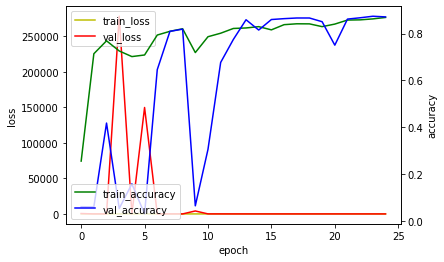

In [13]:
# 5. 학습 과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

## 그래프 : loss , val_loss
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

## loss 그래프
loss_ax.plot(hist.history['loss'],'y',label='train_loss') # 노란색
loss_ax.plot(hist.history['val_loss'],color='red' ,label='val_loss') # 빨간색

## accuracy 그래프
acc_ax.plot(hist.history['accuracy'],'g',label='train_accuracy') # 초록색
acc_ax.plot(hist.history['val_accuracy'],'b',label='val_accuracy') # 파란색

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [14]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(X_test,y_test,batch_size=32)
#변수명 : X_train, X_test, y_train, y_test 
print('##### Test Result #####')
print('loss : ',str(loss_and_metrics[0]))
print('Accuracy : ',str(loss_and_metrics[1]))

# 7. 모델 저장하기
from tensorflow.python.keras.models import load_model
model.save(f'{train_base_dir}/reset50_with_classifiers_88_test_220422_2.h5')

34/34 [==============================] - 5s 112ms/step - loss: 0.5790 - accuracy: 0.8710
##### Test Result #####
loss :  0.5790210366249084
Accuracy :  0.8710280656814575
